# Stock Price Prediction for Five Commodity-Based Companies  

The investment fund management team would like to gain the ability to analyze time series data for stock price forecasting. As a first use case, they would like to start predicting the value of stocks of commodity-producing companies, based on historical data on some specific stocks.

A script executed below will analyze the stock price history of the following commodity-based companies:

- SuperPower Batteries (SUBAT): a company that produces clean energy by harvesting the enthusiasm emitted from educational gameplay; 

- Jack & Jill (JAJIL): this company is among the largest suppliers of bulk hill and island building materials;  

- Voyager (VGER6): the largest Western manufacturer of the refined metals used in the construction of flying game drones;  

- Sabre Feeds (SABRE): this company is one of the largest producers of grain-based animal feedstocks in the Americas;  

- CloudAir (CLAIR): this company is considered the largest producer of rarified gasses in the world;  

The data will be divided into 7 features for each day: lowest, highest, open, closed and adjusted close price, as well as volume and ticker.

### Code Cell 1

In [1]:
#ensure we have the latest pip
%pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


### Code Cell 2

In [2]:
# ensure our application has all of the libraries and versions it requires to run
%pip install -U sagemaker
%pip install botocore
%pip install --upgrade awscli
%pip install tensorflow
%pip install s3fs
%pip install matplotlib
%pip install plotly
%pip install nbformat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: attrs
    Found existing installation: attrs 23.2.0
    Uninstalling attrs-23.2.0:
      Successfully uninstalled attrs-23.2.0
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.245.0
    Uninstalling sagemaker-2.245.0:0m╺━━━━━━━━━━━━━━━━━━━ 1/2 [sagemaker]
      Successfully uninstalled sagemaker-2.245.0━━━━━━━━━━━━━━ 1/2 [sagemaker]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [sagemaker]/2 [sagemaker]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB

### Code Cell 3

In [3]:
# load needed packages and utilities
import numpy as np
import pandas as pd
import datetime
import plotly.graph_objects as go
import os
import json

#import specific packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline


### Code Cell 4

In [7]:
# save the data bucket name here, the one we copied on the S3 menu.
lab_data_bucket_name = "data-lake-bucket-774658689214-us-east-1"

### Code Cell 5

In [8]:
# listing the companies and gathering the data
stock_list = ["SUBAT.CQ", "JAJIL.CQ", "VGER6.CQ", "SABRE.CQ", "CLAIR.CQ"]
stock_data_url = f"s3://{lab_data_bucket_name}/finance/stock/stock.parquet" # There's this single parquet file of data inside the s3 bucket

# Listing the companies and gathering the data

### Code Cell 6

In [9]:
#read stocks into data frame
df = pd.read_parquet(stock_data_url)
df.head()

,symbol,date,volume,low,open,high,close,adjclose,dividends,splits
0,SUBAT.CQ,2019-05-27,33892000.0,26.170000,26.299999,26.540001,26.240000,13.848348,0.0,0.0
1,SUBAT.CQ,2019-05-28,60774600.0,26.129999,26.129999,26.799999,26.799999,14.143891,0.0,0.0
2,SUBAT.CQ,2019-05-29,43124400.0,26.260000,26.490000,26.709999,26.500000,13.985564,0.0,0.0
3,SUBAT.CQ,2019-05-30,71847200.0,25.990000,26.510000,26.860001,26.150000,13.800850,0.0,0.0
4,SUBAT.CQ,2019-05-31,63137200.0,25.420000,25.790001,26.270000,25.549999,13.484196,0.0,0.0


For the sake of convenience in the later steps, let's scale the adjclose for JAJIL now. This will result in better efficiency in the models as well as allow us to compare the prices in a relative way, which makes the performance easier to visualize.

### Code Cell 7

In [10]:

scaler = MinMaxScaler() # We instanciate a MixMaxScaler inside the scaler variable, the exact transformation formula is this one (x - min)/(max - min), extremely sensible to outliers, yes.
index = df[df.symbol == "JAJIL.CQ"].index # Extracts the indices where symbol column has "JAJIL.CQ" value
df.loc[index, "adjclose"] = scaler.fit_transform(df.loc[index].adjclose.values.reshape(-1, 1)) # We update the values of the df for the rows corresponding to the index and to the adjclose column to be the scaled version of the same values but rearranged from [100, 150, 200] (which is the output of .values) to [[100],[150],[200]] (which is the output of .reshape(-1, 1), and here -1 means whatever the length of the .values numpy array and we are using its built-in method .reshape upon). [[100],[150],[200], ...] is read like n rows, 1 column as opposed to [[100, 150, 200, ...]] which would mean 1 row, n columns. Thumb rule, iterate inner brackets first dimension, if iterate INSIDE the second nested bracket we are inside the next dimension (the columns). You do it because you need to adjust the data to df.loc[index, "adjclose"]'s shape.
df.loc[index]

,symbol,date,volume,low,open,high,close,adjclose,dividends,splits
4937,JAJIL.CQ,2015-12-30,5226600.0,12.630000,12.880000,13.14,13.030000,0.032212,0.0,0.0
4938,JAJIL.CQ,2016-01-04,4587900.0,12.480000,12.490000,12.98,12.690000,0.029740,0.0,0.0
4939,JAJIL.CQ,2016-01-05,2693500.0,12.410000,12.670000,12.84,12.520000,0.028504,0.0,0.0
4940,JAJIL.CQ,2016-01-06,6758900.0,11.590000,12.080000,12.11,11.600000,0.021814,0.0,0.0
4941,JAJIL.CQ,2016-01-07,6450400.0,10.880000,11.260000,11.37,10.910000,0.016797,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
32496,JAJIL.CQ,2017-01-03,5658500.0,25.400000,25.510000,26.17,26.170000,0.128875,0.0,0.0
32497,JAJIL.CQ,2017-01-04,2144400.0,25.360001,26.059999,26.23,25.700001,0.125438,0.0,0.0
32498,JAJIL.CQ,2017-01-05,4031600.0,25.780001,25.980000,26.90,26.680000,0.132605,0.0,0.0
32499,JAJIL.CQ,2017-01-06,4213500.0,25.860001,26.290001,26.59,25.969999,0.127412,0.0,0.0


### Code Cell 8

In [11]:
df.shape

(32501, 10)

### Code Cell 9

In [12]:
#import again here to make it available within the scope of this code block
from datetime import datetime

# Spliting the data into train and test
def split_data(df, company_list, prediction_leght, startdate = '2018-01-02'):
    """
        Receive a dataframe with one company or more, as well as a company list and split the data into train and test 
        by the date given as input for each company.
        
        Inputs:
        - df: a dataframe containing at least timestamps and the target columns
        - company_list: a list of company present in the df. They will be splited and formated
        - prediction length: the number of timestamps that should be separeted as test data
        - start_date: is the start of our dataset. Default is the startdate for BOVV11
        
        Returns:
        2 dictionaries containing the train and test datasets for each company. The datasets contain just
        the date column as well as the adjclose (target) column.
    """
    startdate = datetime.strptime(startdate, '%Y-%m-%d').date() # we use the %Y-%m-%d format to parse the string containing the date to a date type, .date() is used to cut the time, otherwise we would have a datetime object
    # We initiate the dictionaries that will contain test and train data
    train = {}
    test = {} 

    for company in company_list: # for each company in the company list we provide will afterwards provide to the split_data function: 
        train[company] = df[(df.symbol == company) & (df.date > startdate)][:-prediction_length][["date", "adjclose"]]
        test[company] = df[(df.symbol == company) & (df.date > startdate)][-prediction_length:][["date", "adjclose"]]
        # I guess rows are ordered by date on an ascending order so:
        # We put the rows (each row is a different day) of a given company inside the train dictionary corresponding to dates after start_date that come before the n (prediction length number) last rows and only selecting "date" and "adjclose" column from the rows.
        # The last n (prediction length number) rows go the test dictionary. The rest of the filtering conditions are kept the same as the one on the train dictionary.
    return train, test

### Code Cell 10

In [13]:
# Defining the timespan to make it efficient and easier for the future
timespan = 90
prediction_length = timespan

# Spliting the data
train, test = split_data(df, stock_list, prediction_length)

### Code Cell 11

In [14]:
train

{'SUBAT.CQ':              date   adjclose
 0      2019-05-27  13.848348
 1      2019-05-28  14.143891
 2      2019-05-29  13.985564
 3      2019-05-30  13.800850
 4      2019-05-31  13.484196
 ...           ...        ...
 14485  2020-05-26  10.678394
 14486  2020-05-27  10.819546
 14487  2020-05-28  10.732683
 14488  2020-05-29  11.042125
 14489  2020-06-01  11.036695
 
 [1868 rows x 2 columns],
 'JAJIL.CQ':              date  adjclose
 5953   2018-01-03  0.254247
 5954   2018-01-04  0.255546
 5955   2018-01-05  0.260511
 5956   2018-01-08  0.267691
 5957   2018-01-09  0.266469
 ...           ...       ...
 32150  2018-09-03  0.367069
 32151  2018-09-04  0.350775
 32152  2018-09-05  0.351967
 32153  2018-09-06  0.362539
 32154  2018-09-10  0.360472
 
 [1356 rows x 2 columns],
 'VGER6.CQ':              date   adjclose
 7239   2019-10-09  11.621934
 7240   2019-10-10  12.239028
 7241   2019-10-11  12.454076
 7242   2019-10-14  12.379276
 7243   2019-10-15  12.734573
 ...           ...  

### Code Cell 12

In [15]:
test
# Some of the dates are not ordered so they must assume its not important that previous dates go to train data and last dates to go test, thet only need a bunch of dates in test and the rest on train. 

{'SUBAT.CQ':              date   adjclose
 14490  2020-06-02  11.617573
 14491  2020-06-03  11.655575
 14492  2020-06-04  11.633861
 23202  2018-01-03   8.410765
 23203  2018-01-04   8.425876
 ...           ...        ...
 23284  2018-05-03  11.306686
 23285  2018-05-04  11.216034
 23286  2018-05-07  11.407415
 23287  2018-05-08  11.538362
 29943  2019-05-24  13.769181
 
 [90 rows x 2 columns],
 'JAJIL.CQ':              date  adjclose
 32155  2018-09-11  0.355465
 32156  2018-09-12  0.362300
 32157  2018-09-13  0.364923
 32158  2018-09-14  0.376210
 32159  2018-09-17  0.374938
 ...           ...       ...
 32240  2019-01-18  0.372712
 32241  2019-01-21  0.376845
 32242  2019-01-22  0.375256
 32243  2019-01-23  0.379786
 32244  2019-01-24  0.383760
 
 [90 rows x 2 columns],
 'VGER6.CQ':              date   adjclose
 27278  2018-05-21   7.036467
 27279  2018-05-22   7.145318
 27280  2018-05-23   6.764338
 27281  2018-05-24   6.686587
 27282  2018-05-25   6.352258
 ...           ...      

## Upload to S3

In order to train a model in SageMaker, we need to first upload the data to an S3 bucket.

### Code Cell 13

In [16]:
# Saving the train and test data on data folder inside this Jupyter Lab environment.
for stock in stock_list:
    train[stock].to_csv("./data/train_{}.csv".format(stock[:4].lower()), index = False)
    test[stock].to_csv("./data/test_{}.csv".format(stock[:4].lower()), index = False)

### Code Cell 14

In [17]:
# Importing general AWS session configuration
import boto3
import sagemaker
from sagemaker import get_execution_role # right now this notebook is obsolete, this line creates an error because the version installed above has decrecated get_execution_role function 
# These commands are pretty self-explanatory, we initiate a sagemaker session using the s3 bucket as the default bucket to be able to access it 
session = sagemaker.Session(default_bucket=lab_data_bucket_name)
role = get_execution_role() # We save the role used in sagemaker in "role"

bucket = session.default_bucket() # We save the default bucket in "bucket"


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


### Code Cell 15

In [18]:
# Creating specific configuration
prefix = "stock-price-forecast-project" # prefix to add to S3 address
data_dir = "./data" # the directory where data is stored now on the Jupyter Lab environment
paths = {} 

# Addressing the data on the disc
train_key = os.path.join(data_dir, "train_{}.csv".format("jaji")) # From all the paths we have made in the ./data folder inside Jupyter Lab we will only save in s3 data from JAJIL.CQ, which can be found in "./data/train_jaji.csv" we will save this as a variable "train_key"
test_key = os.path.join(data_dir, "test_{}.csv".format("jaji")) # The same as above but for ./data/test_jaji.csv. os.path.join because it takes the strings you provide and joins them using the correct path separator for the OS your Python program is currently running on, in the cloud we don't know 4 sure what are we using.

# Path where the files will be saved
train_prefix = "{}/{}".format(prefix, "train_{}".format("jaji")) # The create the path inside the S3 where the data will be saved
test_prefix = "{}/{}".format(prefix, "test_{}".format("jaji")) # Same as above, these are all subfolders, the final file path will result in "s3://bucket/stock-price-forecast-project/test_jaji/test_jaji.csv" and "s3://bucket/stock-price-forecast-project/train_jaji/train_jaji.csv" with train/test_jaji repeated one time, yes.

# Uploading to S3, the resulting S3 train URI stated above will appear inside paths dictinory with key "train" and the test URI will appear written as the value for the key "test". Even if we use session.upload_data to fill the dictionary it won't prevent the execution but instead will prompt the execution of the upload_data command while also copying the resulting URI as the value of the each as stated before.
paths["train"] = session.upload_data(train_key, bucket = bucket, key_prefix = train_prefix)
paths["test"] = session.upload_data(test_key, bucket = bucket, key_prefix = test_prefix)

## Model Building

Now, we will build two models and compare them to predict stock prices.  

The timespan that we are interested in is 3 months, so for each model we are going to compare RMSE and MAE. We will also visualize the quality of the predictions by using a line graph with the prediction and real values for the last 90 days.

## Random Cut Forest Regressor - Baseline

To start our model development task, it is a standard practice to have a baseline model so we can use it to compare future models, so we can see if we are making progress in refining our models.   

For this task we will create three types of basic models:
- Differentiation of the next row
- Lag from the original target
- Moving Average

### Code Cell 16

In [19]:
from sklearn.ensemble import RandomForestRegressor

### Code Cell 17

In [20]:
# Let's concatanete the train and test dataframes to do just one feature engineering process
df_rf = pd.concat([train["JAJIL.CQ"], test["JAJIL.CQ"]]) # Union in SQL 
df_rf.index = df_rf.date # The new df's index is tha data column
df_rf = df_rf.drop("date", axis = 1) # We have it on the  index, we can erase it then
df_rf.head() # Show the first 5 rows

,adjclose
date,
2018-01-03,0.254247
2018-01-04,0.255546
2018-01-05,0.260511
2018-01-08,0.267691
2018-01-09,0.266469


Now let's develop the features of these models...

### Code Cell 18

In [21]:
# Applying the diff to the data
df_rf["adj_close_diff"] = df_rf.diff() # Calculates the difference between the actual row and the previous one using the temporal index as the reference.

# Calculating 10 lags for starting
for i in range (5, 0, -1): # for 5, 4, 3, 2, 1 
    df_rf['t-' + str(i)] = df_rf.adjclose.shift(i) # create each time a column names t-x in df_rf that contains the value of is the previous (row_number - ith_number) 

# Moving Avg of 2 weeks
df_rf["rolling"] = df_rf.adjclose.rolling(window = 14).mean() # Create the rolling mean using the 14 previous row.

df_rf.dropna(inplace = True) # Eliminate the rows that contain NA values because they are in the beginning and previous rows are not available to compute values for the columns above created, inplace applies the change to the dataframe
df_rf.head() # First five rows

,adjclose,adj_close_diff,t-5,t-4,t-3,t-2,t-1,rolling
date,,,,,,,,
2021-03-03,0.790433,-0.010625,0.769863,0.750994,0.740879,0.775303,0.801058,0.488234
2021-03-04,0.777768,-0.012665,0.750994,0.740879,0.775303,0.801058,0.790433,0.525628
2021-03-05,0.827616,0.049847,0.740879,0.775303,0.801058,0.790433,0.777768,0.566491
2021-03-08,0.822819,-0.004797,0.775303,0.801058,0.790433,0.777768,0.827616,0.606655
2021-03-09,0.813936,-0.008883,0.801058,0.790433,0.777768,0.827616,0.822819,0.645673


Now that we have a dataframe to work with, we can feed it into a basic random forest regressor. But first, let's split the data into train and test versions.

### Code Cell 19

In [22]:
X_train_rf = df_rf.iloc[:-timespan].drop("adjclose", axis = 1) # All train columns in train span excluding the target variable with the timaspan
y_train_rf = df_rf.iloc[:-timespan].adjclose # The objective column on the train span 

X_test_rf = df_rf.iloc[-timespan:].drop("adjclose", axis = 1) # The train columns in the test span
y_test_rf = df_rf.iloc[-timespan:].adjclose # The target column in the test span

### Code Cell 20

In [23]:
# Checking the shape they should have 
X_train_rf.shape, X_test_rf.shape, y_train_rf.shape, y_test_rf.shape

((1343, 7), (90, 7), (1343,), (90,))

### Code Cell 21

In [24]:
# Instanciating a Regressor and Training
regressor_rf = RandomForestRegressor(n_estimators = 1000)

# Training 
regressor_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(n_estimators=1000)

### Code Cell 22

In [25]:
prediction_rf = regressor_rf.predict(X_test_rf) # Use the fitted model to predict on the test_X data 

Now that we have the predictions, let's transform it back to its un-scaled form.

### Code Cell 23

In [26]:
prediction_rf = scaler.inverse_transform(prediction_rf.reshape(1, -1)) # It is possible that the reshape is wrong and should be .reshape(-1, 1) as when we trained the scaler since the inverse_transform function expects (n_samples, n_features) and we are passing 90 samples of a single feature, it it also possible that since there's a single feature you pass it like that and the transformation is the same.
y_test_rf = scaler.inverse_transform(y_test_rf.values.reshape(1, -1)) # Same as above

### Code Cell 24

In [27]:
# RMSE
rf_RMSE = np.sqrt(mean_squared_error(y_test_rf, prediction_rf))
rf_RMSE 

0.6200464774291893

### Code Cell 25

In [28]:
# MAE
rf_MAE = mean_absolute_error(y_test_rf, prediction_rf)
rf_MAE

0.41136051211887964

Now, let's visualize this behaviour in a line graph.

### Code Cell 26

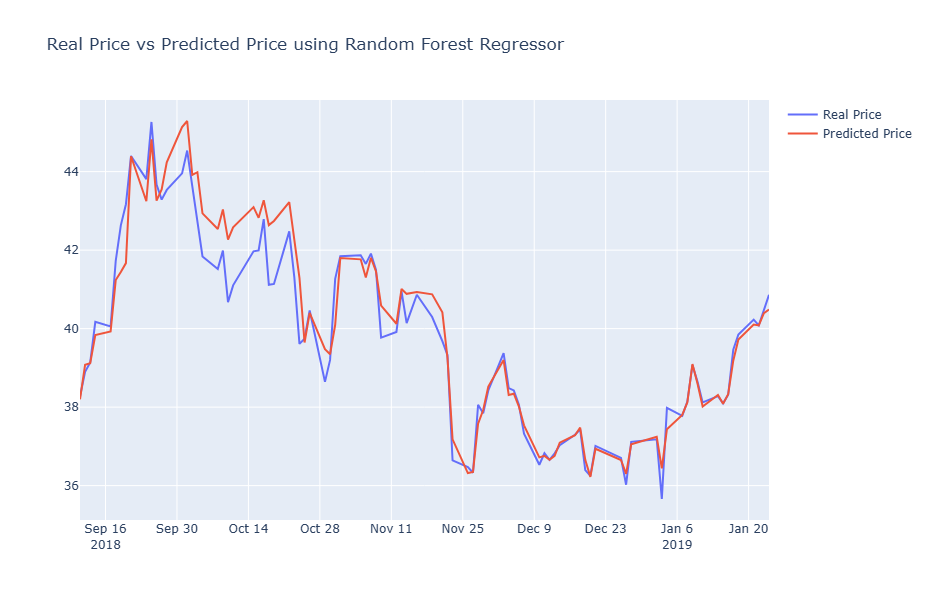

In [29]:
trace1 = go.Scatter(x = X_test_rf.index, y = y_test_rf[0], # We use [0] because we reshaped it and we extract the first dimensionfrom the 2d array.
                   mode = 'lines',
                   name = 'Real Price')

trace2 = go.Scatter(x = X_test_rf.index, y = prediction_rf[0], # We use [0] because we reshaped it and we extract the first dimensionfrom the 2d array.
                    mode = "lines",
                    name = "Predicted Price")

layout = go.Layout(title = "Real Price vs Predicted Price using Random Forest Regressor",
                   width = 1000, height = 600)

fig = go.Figure(data = [trace1, trace2], layout = layout)
fig.show()

## LSTM Model with TensorFlow


### Code Cell 27

In [30]:
from sagemaker.tensorflow import TensorFlow

### Code Cell 28

In [31]:
from sagemaker.predictor import Predictor

### Code Cell 29

In [32]:
# Setting up the output path
output_path = "s3://{}/{}/output".format(bucket, prefix)

# Setting the instance type, batch size, and epoch size variables
TF_FRAMEWORK_VERSION = '2.11.0'
instancetype = "ml.m5.xlarge" # AWS hardware instance to use
batchsize = 32 
epochsize = 25 

regressor_tf = TensorFlow(
    entry_point='train.py', # The script to run 
    role=role, # we use the permissions of this role
    framework_version=TF_FRAMEWORK_VERSION, # Version 2.11.0
    model_dir = False, # False: SageMaker will use a temporary path and copy artifacts to 'output_path'
    py_version='py39', # Python version for the container (e.g., 3.9)
    instance_type=instancetype,
    instance_count=1, # Not distributed training, we only use one machine
    output_path=output_path, # Defined above
    hyperparameters={
        'batch-size':batchsize, # Also defined above
        'epochs':epochsize}) # Also defined above

### Code Cell 30

In [ ]:
regressor_tf.fit(paths["train"])
# We use the S3 URI stored in the paths dictionary under the key "train" 

### Code Cell 31

In [35]:
predictor_tf = regressor_tf.deploy(initial_instance_count=1, instance_type=instancetype) # We create an endpoint in sagemaker where we can pass the data to make inferences with the LSTM model.

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-774658689214
INFO:sagemaker:Creating model with name: tensorflow-training-2025-07-05-09-14-25-085
INFO:sagemaker:Creating endpoint-config with name tensorflow-training-2025-07-05-09-14-25-085
INFO:sagemaker:Creating endpoint with name tensorflow-training-2025-07-05-09-14-25-085


-----!

### Code Cell 32

In [36]:
# We could already use the endpoint deployed but here is where the steps of the lab tell us to COPY the endpoint generated above navigating to endpoints in the sagemaker manu on the console and paste it endpoint_name, in my case the name was tensorflow-training-2025-07-05-09-14-25-085, this is redudant as I said but is useful to see how to use an already existent endpoint.
predictor_tf = Predictor(
    endpoint_name="tensorflow-training-2025-07-05-09-14-25-085",
    sagemaker_session=sagemaker.Session(),
    serializer=sagemaker.serializers.JSONSerializer() # We use it so the data sent to the endpoint is not raw data in bytes but instead in JSON format readable from the train.py script.
)

In order to make predictions, we need to first prepare the data with its lags. 

### Code Cell 33

In [37]:
# train and test dictionaries shown in data cells 11 and 12
train_input_tf = train["JAJIL.CQ"].adjclose.values.reshape(-1,1) # we extract the dataframe corresponding to the JAJIL company stored in its corresponding key in train dictionary, we only select the adjclose column and extract the numpy array of its values and then reshape it as single column full of rows like [[a], [b], [c], [...]]
test_input_tf = test["JAJIL.CQ"].adjclose.values.reshape(-1,1) # we do exactly the same procedure as above only on the test dictionary 

### Code Cell 34

In [38]:
df_volume = np.vstack((train_input_tf, test_input_tf)) # we vertically stack the train and test numpy arrays because we reshaped them as (-1, 1)
window = 30 # number of lags

inputs = df_volume[df_volume.shape[0] - test_input_tf.shape[0] - window:] # We are slicing data to exclude all data except for the test and the window (yes we have a bit of training data due to the window but is okay and common when training LSTM)
inputs = inputs.reshape(-1, 1) # Once again we reshape in one column because slicing can break the posture 

prediciton_lengh = df_volume.shape[0] - train_input_tf.shape[0] + window # This is the amount of data point we find in the slice [df_volume.shape[0] - test_input_tf.shape[0] - window : ] since here we have included the test and the window and that is exactly what we have in df_volume.shape[0] - train_input_tf.shape[0] + window (all data - train data + window = test_data + window) 

X_test = []

for i in range(window, prediciton_lengh): # for i spanning from 30 to prediciton_lengh
    X_test_reshaped = np.reshape(inputs[i-window:i], (window, 1)) # i-window gives every possible starting position within the range of the input and window gives this position 30 steps ahead. That way it's easy to see how that works 
    X_test.append(X_test_reshaped) # We append each iteration to X_test and end up with a number of (window, 1) arrays equal to prediciton_lengh - window.

X_test = np.stack(X_test) # We do that because we want to transform the structure of a list of (prediciton_lengh - window) elements consisting of 2 dimensional arrays of (window, 1) to a single 3 dimensional numpy array of shape (prediciton_legngh - window, window, 1). We include the third level inside the numpy array instead leaving it as a list
# We do that because the input for a LSTM follows the structure (samples (number of instances), timesteps (the number of delayed events), features (here we only use the delayed price so this dimension is equal to 1))

### Code Cell 35

In [39]:
predictor_tf.predict(X_test) # We enter the data to the predictor endpoint and that's the aspect of the JSON data it returns

b'{\n    "predictions": [[0.347723961], [0.34817487], [0.349596143], [0.351837933], [0.355947256], [0.360618412], [0.367370427], [0.37626496], [0.385931432], [0.39622885], [0.404201806], [0.411213636], [0.41419065], [0.412800372], [0.40943253], [0.406843543], [0.40687716], [0.407362878], [0.405974627], [0.401456237], [0.394974828], [0.389557421], [0.384227276], [0.380249858], [0.379557431], [0.381489515], [0.385834932], [0.387986362], [0.387260318], [0.387120605], [0.386312306], [0.38195616], [0.375623822], [0.370831668], [0.365561694], [0.361193955], [0.361974], [0.367833912], [0.375724286], [0.382303655], [0.386603773], [0.387931943], [0.384168208], [0.377672017], [0.37304467], [0.37012732], [0.369805396], [0.370323539], [0.369699597], [0.36735636], [0.359650135], [0.348717928], [0.338013977], [0.33303833], [0.333381832], [0.337617159], [0.344688177], [0.350509], [0.353424758], [0.353126], [0.349665612], [0.343548238], [0.337448984], [0.332770586], [0.33030647], [0.330072045], [0.331

### Code Cell 36

In [40]:
# Making predictions
try:
    # We try directly reading the output from the endpoint
    predictions_byte = predictor_tf.predict(X_test)
    prediction_tf = np.array(predictions_byte["predictions"])
    print('1')
except: 
    # But we see its not possible because we used a JSON serializer so we must treat it as a JSON:
    predictions_json = json.loads(predictions_byte)
    prediction_tf = np.array(predictions_json["predictions"])
    print('2')

2


### Code Cell 37

In [41]:
# Scaling the predictions back, we don't reshape the JSON output and then the resulting numpy array already has the structure [[a], [b], [...]...] 
prediction_tf = scaler.inverse_transform(prediction_tf).flatten() # flattern() turns it into a 1d array

### Code Cell 38

In [42]:
# RootMeanSquaredError
tf_RMSE = np.sqrt(mean_squared_error(y_test_rf[0], prediction_tf))
tf_RMSE

1.4798006018142416

### Code Cell 39

In [43]:
# MeanAbsoluteError
tf_MAE = mean_absolute_error(y_test_rf[0], prediction_tf)
tf_MAE

1.1957980047738332

### Code Cell 40

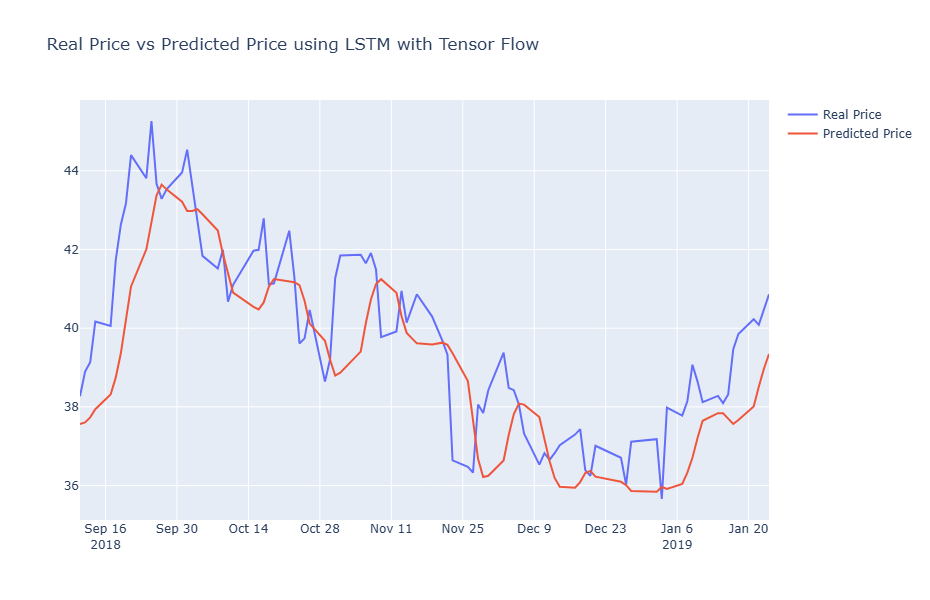

In [44]:
# This graph makes the same as the graph above but for the LSTM prediction 
trace1 = go.Scatter(x = X_test_rf.index, y = y_test_rf[0], # We use [0] because we reshaped and we extract the first dimensionfrom the 2d array.
                   mode = 'lines',
                   name = 'Real Price')

trace2 = go.Scatter(x = X_test_rf.index, y = prediction_tf,
                   mode = "lines",
                   name = "Predicted Price")

layout = go.Layout(title = "Real Price vs Predicted Price using LSTM with Tensor Flow",
                   width = 1000, height = 600)

fig = go.Figure(data = [trace1, trace2], layout = layout)
fig.show()

With the result for the two models as well its scores, we can then move forward and explore the results.

## Results

Now that we have our models trained and evaluated on a test set, we can compare the metrics and use visualization to get insights on how good they are and how close they were to the forecast. 

Let's begin by comparing the metrics RMSE and MAE for each model.

### Code Cell 41

In [45]:
tf_MAE

1.1957980047738332

### Code Cell 42

In [ ]:
import pandas as pd
metrics = {"RMSE": [rf_RMSE, tf_RMSE], "MAE": [rf_MAE, tf_MAE]}
pd.DataFrame(metrics, index = ["Random Forest", "LTSM"] )

### Code Cell 43

In [ ]:
# Forgot to run this graoh but it's just the combination of two previous graphs overlayed. 
trace1 = go.Scatter(x = X_test_rf.index, y = y_test_rf[0], # We use [0] because we reshaped
                   mode = 'lines',
                   name = 'Real Price')

trace2 = go.Scatter(x = X_test_rf.index, y = prediction_rf[0], # We use [0] because we reshaped
                   mode = "lines",
                   name = "Predicted Price RF")


trace3 = go.Scatter(x = X_test_rf.index, y = prediction_tf, 
                   mode = "lines",
                   name = "Predicted Price LSTM")

layout = go.Layout(title = "Comparing the Results of Random Forest and LSTM models with the Real Price",
                   width = 1000, height = 600)

fig = go.Figure(data = [trace1, trace2, trace3], layout = layout)
fig.show()

Looking at the graph above, we can see that both models did a very good job in this forecast task.  

## Storing Results in S3, to be consumed by business users

### Code Cell 44

In [ ]:
result_set_df = X_test_rf # Original pandas dataframe
result_set_df 

real_price_array = y_test_rf[0] # Again, we extract first dimension from the 2d array.
real_price_array
real_price_df = pd.DataFrame(real_price_array, columns = ['real_price']) # We create a new dataframe with a column containing real prices

predicted_price_array = prediction_tf
predicted_price_array
predicted_price_df = pd.DataFrame(predicted_price_array, columns = ['predicted_price']) # We create a new dataframe with a column containing predicted prices
predicted_price_df

result_set_df['real_price'] = real_price_df.values # We insert the real prices column on the result_set_df
result_set_df['predicted_price'] = predicted_price_df.values # We insert the predicted prices column on the result_set_df
result_set_df['ticker'] = 'JAJIL.CQ'

### Code Cell 45

In [ ]:
result_set_df.to_parquet(f's3://{lab_data_bucket_name}/finance/predictions/predictions.parquet') # We save the dataframe as a parquet using the path of the f-string

### References

[1] https://medium.datadriveninvestor.com/using-aws-sagemaker-to-stock-price-forecast-of-brazilian-commodity-based-companies-f937572b7654
[2] https://en.wikipedia.org/wiki/Fundamental_analysis#The_two_analytical_models  
[3] https://en.wikipedia.org/wiki/Technical_analysis  
[4] https://www.thebalance.com/brazil-and-commodities-808912  
[5] https://www.nasdaq.com/articles/3-reasons-why-commodities-etfs-may-rally-in-2021-2021-01-15  
[6] https://www.reuters.com/article/column-russell-commodities-yearahead-idUSL1N2IQ0A2    
[7] https://plusmining.com/en/commodities-rally-is-projected-to-2021-the-coronavirus-would-mark-a-milestone-in-the-cycle-potentially-leaving-years-of-weak-prices-behind/  
[8] https://www.fxempire.com/forecasts/article/speculators-bet-on-a-continued-commodity-rally-in-2021-690009  
[9] https://www.kaggle.com/miracl16/tesla-stock-price-prediction-lstm-vs-gru     
[10] https://www.kaggle.com/fatmakursun/tesla-stock-price-prediction  
[11] https://www.kaggle.com/akanksha496/stock-price-prediction-lstm   
[12] https://www.kaggle.com/raoulma/ny-stock-price-prediction-rnn-lstm-gru  
[13] https://www.kaggle.com/biphili/time-series-data-analysis-stock-price-code-12#5.Forecasting-Stock-Price   
[14] https://towardsdatascience.com/python-for-finance-stock-portfolio-analyses-6da4c3e61054
